In [78]:
import requests
import json
from PIL import Image
from io import BytesIO
import base64
import numpy as np 
import cupy as cp
import sys
from cuvs.neighbors import hnsw,cagra
import os
import time
import cudf
import cugraph
from itertools import combinations
sys.path.append('/hpc2hdd/home/ysi538/retrieval')
from MDI_RAG_Image2Image_Research.src.utils.encoder import WSI_Image_UNI_Encoder

from utils import *

In [79]:
def load_index_file(index_file):
    index = hnsw.load(hnsw.IndexParams(),index_file, 1024, np.float32, "sqeuclidean")
    return index

def load_info_file(info_file):
    with open (info_file, 'r') as f:
        infos = json.load(f)
    return infos



def search(index, encoder, infos_list, query_path,split_img_fun, top_k=50):
    total_neighbors = []
    total_distances = []
    query_image = request_image(query_path)
    # 根据图片比例尺寸，切割图片
    img_other_info = None
    split_imgs = split_img_fun(query_image, img_other_info)
    # 编码后的向量存储到一个二维 np.array 中
    split_embeddings = cp.array([cp.array(encoder.encode_image(after_split_img)).astype('float32') for after_split_img in split_imgs])
    
    # 确保每个 query_embedding 是二维数组
    if split_embeddings.ndim == 1:
        split_embeddings = split_embeddings.reshape(1, -1)
    
    # print("split_embeddings:", split_embeddings)
    # return split_embeddings
    result_infos = []
    
    time_cost = 0
    begin_time = time.time()
    # distances, neighbors = hnsw.search(hnsw.SearchParams(), index, split_embeddings, top_k)
    distances, neighbors = cagra.search(cagra.SearchParams(),index, split_embeddings, top_k)
    end_time = time.time()
    time_cost += end_time - begin_time
   
    
    neighbors = cp.asarray(neighbors).flatten().tolist()
    distances = cp.asarray(distances).flatten().tolist()
    for neighbor in neighbors:
        result_infos.append(infos_list[neighbor])
    total_neighbors.extend(neighbors)
    total_distances.extend(distances)

    total_distances, total_neighbors, result_infos = zip(*sorted(zip(total_distances, total_neighbors, result_infos)))
    return total_distances[:], total_neighbors[:], result_infos[:], time_cost


In [80]:

image_encoder = WSI_Image_UNI_Encoder()

ssd_dir = "/hpc2ssd/JH_DATA/spooler/ysi538/"
# hnsw_index = load_index_file(ssd_dir + "cupy_index_batch_0.bin")
infos_list = load_info_file(ssd_dir + "cupy_infos_batch_0.json")

embeddings = cp.load(ssd_dir + "cupy_embeddings_batch_0.npy")
# 转换为 numpy
embeddings = cp.asnumpy(embeddings).astype(np.float32)
embeddings = cp.array(embeddings, dtype=cp.float32)
build_params = cagra.IndexParams(metric="sqeuclidean",build_algo = 'nn_descent')
cuda_index = cagra.build(build_params, embeddings)

cuda
[I] [16:44:50.067423] optimizing graph
[I] [16:45:08.579175] Graph optimized, creating index


In [105]:
def get_combined_regions_gpu(result_infos):
    search_info_list = []
    for info in result_infos:
        search_info = {}
        level = info.split("_")[-1].split(".")[0]
        w = info.split("_")[-3]
        h = info.split("_")[-2]
        x = info.split("_")[-5]
        y = info.split("_")[-4]
        id = info.split("_")[0]
        name = "_".join(info.split("_")[1:-5])
        search_info = {"id": id, "name": name, "x": x, "y": y, "w": w, "h": h, "level": level}
        search_info_list.append(search_info)

    # 构建边列表
    edges = []
    for a, b in combinations(search_info_list, 2):  # 只考虑每对节点一次，避免重复
        if judge_if_connected(a, b):
            edges.append((a, b))

    # 将边列表转换成cudf DataFrame
    edges_df = cudf.DataFrame(edges, columns=['source', 'destination'])

    # 创建一个无向图（因为对于WCC来说，边的方向并不重要）
    G = cugraph.Graph(directed=False)

    # 添加边到图中
    G.from_cudf_edgelist(edges_df, source='source', destination='destination')

    # 计算弱连通分量
    begin_time = time.time()
    wcc_components = cugraph.weakly_connected_components(G)
    end_time = time.time()
    
    
    # 计算弱连通分量
    # wcc_components = cugraph.wcc(G)

    return wcc_components,end_time - begin_time

In [108]:
query_img_path = " metaservice/api/region/openslide/241183-21.tiff/6400/25344/2240/2240/1"
search_begin_time = time.time()
total_distances, total_neighbors, result_infos, pure_search_time = search(cuda_index, image_encoder, infos_list, query_img_path,split_img_fun, 64)
search_end_time = time.time()
search_time_cost = search_end_time - search_begin_time

combine_begin_time = time.time()
combined_regions,pure_combined_cost = get_combined_regions_gpu(result_infos)
combine_end_time = time.time()
combine_time_cost = combine_end_time - combine_begin_time

print("search_total_time_cost:", search_time_cost)
print("combine_time_cost:", combine_time_cost)
print("pure search time cost:", pure_search_time)
print("wcc time cost:", pure_combined_cost)
# len(combined_regions)
# 按label进行groupby
combined_regions_grouped = combined_regions.groupby('labels')
# 获取每个group的大小
group_sizes = combined_regions_grouped.size()
# 按group大小进行排序
group_sizes = group_sizes.sort_values(ascending=False)
group_sizes


/hpc2hdd/home/ysi538/miniconda3/envs/yhre-new/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mdi.hkust-gz.edu.cn'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


search_total_time_cost: 31.765669584274292
combine_time_cost: 10.905914306640625
pure search time cost: 0.05327868461608887
wcc time cost: 0.030918359756469727


labels
875     95
157     68
999     61
118     58
456     31
        ..
1168     2
1492     2
1125     2
1261     2
1160     2
Length: 355, dtype: int64

In [109]:
pure_combined_cost + pure_search_time

0.0841970443725586

In [99]:
url_list = get_url_list(combined_regions, group_sizes)
embeddings_list = get_result_embeddings(url_list[:], image_encoder)
query_embedding = image_encoder.encode_image(request_image(query_img_path).resize((224, 224)))
score_list = []
for embedding in embeddings_list:
    score = np.dot(query_embedding, embedding) / (np.linalg.norm(query_embedding) * np.linalg.norm(embedding))
    score_list.append(score)
score_list


/hpc2hdd/home/ysi538/miniconda3/envs/yhre-new/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mdi.hkust-gz.edu.cn'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/hpc2hdd/home/ysi538/miniconda3/envs/yhre-new/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mdi.hkust-gz.edu.cn'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/hpc2hdd/home/ysi538/miniconda3/envs/yhre-new/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mdi.hkust-gz.edu.cn'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/

[0.506903308846107,
 0.5291962831796779,
 0.5068817035131761,
 0.5123508908878889,
 0.5431533767251984,
 0.5887232982804992,
 0.5332507504810509,
 0.5671862940932385,
 0.4896248160008795,
 0.5366957754829063,
 0.4403846593538911,
 0.49409018600852983,
 0.5307588815779939,
 0.4951927598404482,
 0.5664173157292313,
 0.5656889692906079,
 0.6133808829949595,
 0.4912984000795321,
 0.5537618717475945,
 0.5936272429775657,
 0.6336248725765158,
 0.5909211413753601,
 0.6294575757618183,
 0.474577688076098,
 0.508369681889248,
 0.4429705809733631,
 0.31337015050782363,
 0.42619699566484365,
 0.5192380642509314,
 0.6467767743821009,
 0.4620893842984658,
 0.4094608781326137,
 0.530342651849848,
 0.5250626288982204,
 0.4414480747781634,
 0.5208072363498063,
 0.39767687917105726,
 0.5053653468366202,
 0.3670568640846399,
 0.46504317573998716,
 0.5983501785626771,
 0.27528723447143,
 0.5057642137734084,
 0.31870010227783596,
 0.3196097077971262,
 0.31398806636467,
 0.6010708884181802,
 0.525794760518

In [100]:
# score_list, url_list组合起来按照score进行排序
score_url_list = list(zip(score_list, url_list))
score_url_list = sorted(score_url_list, key=lambda x: x[0], reverse=True)
score_url_list

[(0.6467767743821009,
  ' metaservice/api/region/openslide/46661_Nectin4-宫颈癌-ZG20200907-1-BM(abcam).ibl.tiff/52992/18432/1024/1536/1'),
 (0.6384363814463017,
  ' metaservice/api/region/openslide/47010_CCR8-胰腺癌-230531006TYXA-BM.ibl.tiff/1024/7168/768/1024/2'),
 (0.6336248725765158,
  ' metaservice/api/region/openslide/6947_2113040-79_无淋巴结转移.tiff/13056/6912/2048/1280/2'),
 (0.6294575757618183,
  ' metaservice/api/region/openslide/46776_Nectin4-尿路上皮癌-230613011TNLS-BM(BY).ibl.tiff/7424/28160/1792/1280/1'),
 (0.6133808829949595,
  ' metaservice/api/region/openslide/46776_Nectin4-尿路上皮癌-230613011TNLS-BM(BY).ibl.tiff/4608/28672/2048/1792/1'),
 (0.6127376325973918,
  ' metaservice/api/region/openslide/46661_Nectin4-宫颈癌-ZG20200907-1-BM(abcam).ibl.tiff/5376/9728/768/768/2'),
 (0.6010708884181802,
  ' metaservice/api/region/openslide/46776_Nectin4-尿路上皮癌-230613011TNLS-BM(BY).ibl.tiff/10752/28928/1792/1024/1'),
 (0.5983501785626771,
  ' metaservice/api/region/openslide/46661_Nectin4-宫颈癌-ZG20200907-1

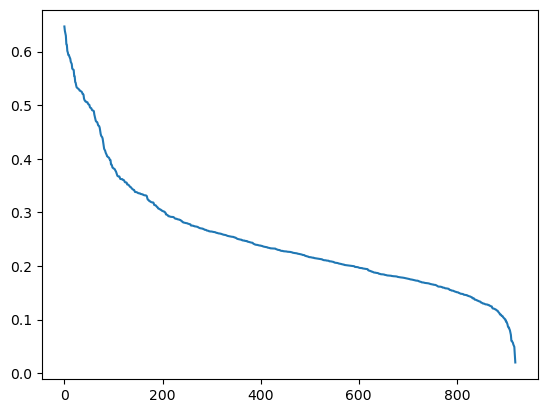

top1: 0.6467767743821009
top3: 0.6396126761349729
top5: 0.6323352974323393
top10: 0.616102858407725
top50: 0.5526012509307496


In [101]:
# score_list画图
import matplotlib.pyplot as plt
sorted_score_list = sorted(score_list, reverse=True)
plt.plot(sorted_score_list)
plt.show()
print("top1:", np.mean(sorted_score_list[:1]))
print("top3:", np.mean(sorted_score_list[:3]))
print("top5:", np.mean(sorted_score_list[:5]))
print("top10:", np.mean(sorted_score_list[:10]))
print("top50:", np.mean(sorted_score_list[:50]))


In [24]:
group_sizes.index[:10]
# 对每个label对应的所有region进行

Index([4084, 450, 408, 562, 824, 2543, 790, 326, 624, 3558], dtype='int32', name='labels')